In [1]:
import numpy as np
import matplotlib.pyplot as plt
from thingsvision.utils.data.dataset import ImageDataset
from functools import partial
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

2022-08-08 14:50:29.606777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 14:50:29.606815: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ImportError: cannot import name 'ImageDataset' from partially initialized module 'thingsvision.dataset' (most likely due to a circular import) (/home/fmahner/.conda/envs/aibehavior/lib/python3.9/site-packages/thingsvision/dataset.py)

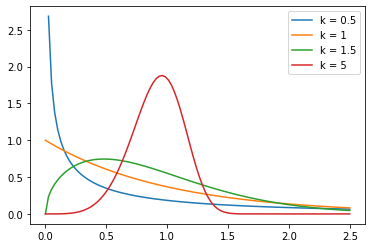

In [113]:
# testing the weibull prior

import torch
import torch.nn as nn
import torch.nn.functional as F
class WeibullPrior(nn.Module):
    def __init__(self, lmbda=1., k=0.5):
        super().__init__()
        self.register_buffer('lmbda', torch.tensor(lmbda)) 
        self.register_buffer('k', torch.tensor(k))
        self.register_buffer('eps', torch.tensor(1e-12))


    def pdf(self, X):
        const = (self.k / self.lmbda)
        term1 = ((X/self.lmbda) ** (self.k-1))
        term2 = torch.exp(-(X / self.lmbda)**self.k)

        # NOTE same as 
        # pdf = (self.k / self.lmbda) * ((X/self.lmbda) ** (self.k - 1)) * torch.exp((-X / self.lmbda)**self.k)
        pdf = const * term1 * term2

        return pdf

    def forward(self, X):
        return self.pdf(X)


fig, ax = plt.subplots(1)
for k in [0.5, 1, 1.5, 5]:
    weib = WeibullPrior(lmbda=1, k=k)


    X = torch.linspace(0, 2.5, 100)
    Y = weib(X)

    ax.plot(X,Y, label='k = ' + str(k))
    
plt.legend()


In [87]:
def pval(W_loc, W_scale, j):
    # the cdf describes the probability that a random sample X of n objects at dimension j 
    # will be less than or equal to 0 in our case) for a given mean (mu) and standard deviation (sigma):
    return norm.cdf(0.0, W_loc[:, j], W_scale[:, j])

def compute_pvals(W_loc, W_scale):
    # Adapted from https://github.com/LukasMut/VICE/utils.py
    # Compute the probability for an embedding value x_{ij} <= 0,
    # given mu and sigma of the variational posterior q_{\theta}
        
    # we compute the cdf probabilities >0 for all dimensions
    fn = partial(pval, W_loc, W_scale)
    n_dim = W_loc.shape[1]
    range_dim = np.arange(n_dim)
    pvals = fn(range_dim)

    return pvals.T

def fdr_corrections(p_vals, alpha = 0.05):
    # Taken from LukasMut/VICE/utils.py    
    # For each dimension, statistically test how many objects have non-zero weight

    fn_reject = lambda p: multipletests(p, alpha=alpha, method='fdr_bh')[0] # true for hypothesis that can be rejected for given alpha
    fdr = list(map(fn_reject, p_vals))
    fdr = np.array(fdr)    

    return fdr

def get_importance(rejections):
    # Taken from LukasMut/VICE/utils.py    
    # Yield the the number of rejections given by the False Discovery Rates
    importance = np.array(list(map(sum, rejections)))
    importance = importance[:, None]
    
    return importance


In [89]:
def compute_pvals(W_loc: np.ndarray, W_scale: np.ndarray) -> np.ndarray:
    # Compute the probability for an embedding value x_{ij} <= 0,
    # given mu and sigma of the variational posterior q_{\theta}
    def pval(W_loc, W_scale, j):
        return norm.cdf(0.0, W_loc[:, j], W_scale[:, j])

    return partial(pval, W_loc, W_scale)(np.arange(W_loc.shape[1])).T


def fdr_corrections(p_vals: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    # For each dimension, statistically test how many objects have non-zero weight
    return np.array(
        list(map(lambda p: multipletests(p, alpha=alpha, method="fdr_bh")[0], p_vals))
    )


def get_importance(rejections: np.ndarray):
    # Yield the the number of rejections given by the False Discovery Rates
    return np.array(list(map(sum, rejections)))[:, np.newaxis]

In [90]:
loc = np.loadtxt('/LOCAL/fmahner/DeepEmbeddings/weights_sslab12_40mio_gamma_099/params/pruned_q_mu_epoch_250.txt')
scale = np.loadtxt('/LOCAL/fmahner/DeepEmbeddings/weights_sslab12_40mio_gamma_099/params/pruned_q_var_epoch_250.txt')

p_vals = compute_pvals(loc, scale)
rejections = fdr_corrections(p_vals, alpha=0.05)
importance = get_importance(rejections).ravel()
signal = np.where(importance > 5)[0]
pruned_loc_lukas = loc[:, signal]
pruned_scale_lukas = scale[:, signal]

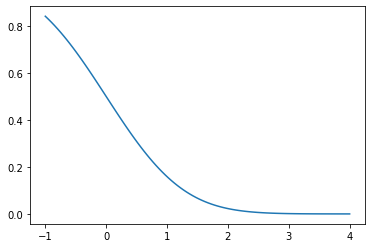

In [64]:
# Plotting the CDF for the Lulz to understand it!
x = np.linspace(-1, 4, 100)
y = norm.cdf(0, x, 1)
plt.plot(x, y)

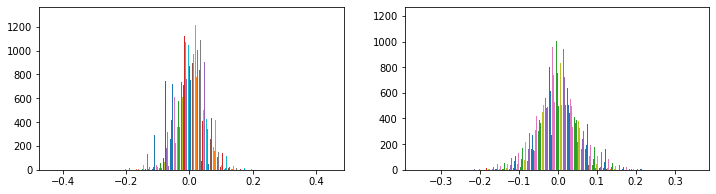

In [20]:


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab12_40mio_gamma_099/params/pruned_q_mu_epoch_50.txt'
weights = np.loadtxt(w_dir)
# weights_relu = np.maximum(weights, 0)
# weights_relu = weights_relu[weights_relu != 0]
weights_relu = weights
ax1.hist(weights_relu, bins=200);

w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab12_40mio_gamma_099/params/pruned_q_mu_epoch_300.txt'
weights = np.loadtxt(w_dir)
# weights_relu = np.maximum(weights, 0)
# weights_relu = weights_relu[weights_relu != 0]
weights_relu = weights
ax2.hist(weights_relu, bins=200);




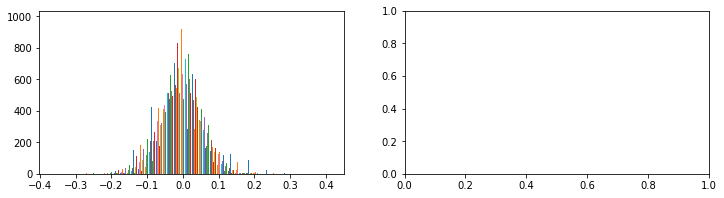

In [22]:


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
# w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_exp_12_1mio_gamma0960/params/pruned_q_var_epoch_200.txt'
w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_exp12_20mio_gamma_099/params/pruned_q_mu_epoch_1550.txt'
weights = np.loadtxt(w_dir)
# weights_relu = np.maximum(weights, 0)
# weights_relu = weights_relu[weights_relu != 0]
weights_relu = weights
# print(weights_relu.shape)
ax1.hist(weights_relu, bins=200);

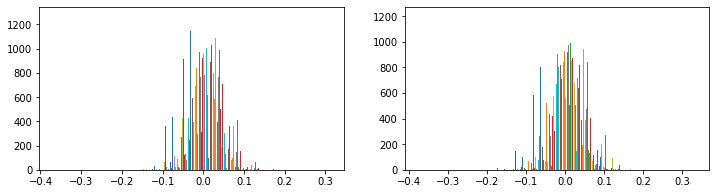

In [5]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab12_5mio_gamma_098/params/pruned_q_mu_epoch_100.txt'
weights = np.loadtxt(w_dir)
# weights_relu = np.maximum(weights, 0)
# weights_relu = weights_relu[weights_relu != 0]
weights_relu = weights
ax1.hist(weights_relu, bins=200);

w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab12_5mio_gamma_099/params/pruned_q_mu_epoch_200.txt'
weights = np.loadtxt(w_dir)
# weights_relu = np.maximum(weights, 0)
# weights_relu = weights_relu[weights_relu != 0]
weights_relu = weights
ax2.hist(weights_relu, bins=200);

In [17]:
from scipy.stats import norm
from functools import partial
from statsmodels.stats.multitest import multipletests
from statistics import NormalDist


def pval(W_loc, W_scale, j):
    # the cdf describes the probability that a random sample X of n objects at dimension j 
    # will be less than or equal to 0 in our case) for a given mean (mu) and standard deviation (sigma):
    return norm.cdf(0.0, W_loc[:, j], W_scale[:, j])

def compute_pvals(W_loc, W_scale):
    # Adapted from https://github.com/LukasMut/VICE/utils.py
    # Compute the probability for an embedding value x_{ij} <= 0,
    # given mu and sigma of the variational posterior q_{\theta}
        
    # we compute the cdf probabilities >0 for all dimensions
    fn = partial(pval, W_loc, W_scale)
    n_dim = W_loc.shape[1]
    range_dim = np.arange(n_dim)
    pvals = fn(range_dim)

    return pvals.T

def fdr_corrections(p_vals, alpha = 0.05):
    # Taken from LukasMut/VICE/utils.py    
    # For each dimension, statistically test how many objects have non-zero weight

    fn_reject = lambda p: multipletests(p, alpha=alpha, method='fdr_bh')[0] # true for hypothesis that can be rejected for given alpha
    fdr = list(map(fn_reject, p_vals))
    fdr = np.array(fdr)    

    return fdr

def get_importance(rejections):
    # Taken from LukasMut/VICE/utils.py    
    # Yield the the number of rejections given by the False Discovery Rates
    importance = np.array(list(map(sum, rejections)))
    importance = importance[:, None]
    
    return importance

Text(0.5, 1.0, 'No ReLU, LL x 10')

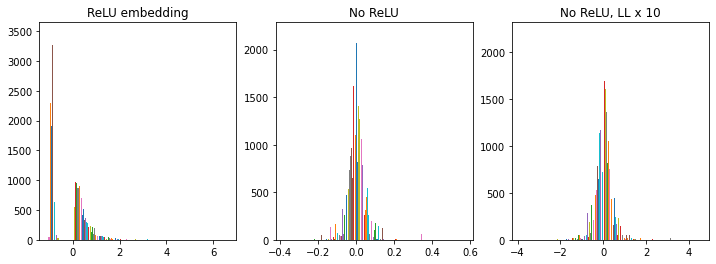

In [41]:




fig, axes = plt.subplots(1, 3, figsize=(12, 4))
w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab6_featact/weights_pruned_epoch_1620.txt'
weights = np.loadtxt(w_dir)
axes[0].hist(weights, bins=100)
axes[0].set_title('ReLU embedding')

w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab6_norelu/weights_pruned_epoch_1000.txt'
weights = np.loadtxt(w_dir)
axes[1].hist(weights, bins=100)
axes[1].set_title('No ReLU')

w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab6_norelu_ll_10/weights_pruned_epoch_1000.txt'
weights = np.loadtxt(w_dir)
axes[2].hist(weights, bins=100);
axes[2].set_title('No ReLU, LL x 10');


In [14]:
w_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab6_norelu/weights_pruned_epoch_1000.txt'
s_dir = '/LOCAL/fmahner/DeepEmbeddings/weights_sslab6_norelu/weights_pruned_epoch_1000.txt'
weights = np.loadtxt(w_dir)
scale = np.loadtxt(w_dir)



In [15]:
pvals = compute_pvals(weights, scale)
fdr = fdr_corrections(pvals)
importance = get_importance(fdr)

In [45]:
importance

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [26]:
weights

(12255,)


In [9]:
# indices = list(combinations(range(n_objects), 2))[:20_000_000]
# random.shuffle(indices)

dataset = ImageDataset(root='/LOCAL/fmahner/THINGS/image_data/images12', out_path='', backend='pt', 
                                        imagenet_train=False, imagenet_val=False,
                                        things=True, things_behavior=False, add_ref_imgs=True,
                                        transforms=None)

idx2obj = dataset.idx_to_cls
obj2idx = dataset.cls_to_idx
images = dataset.images

In [14]:
obj2idx

{'aardvark': 0,
 'abacus': 1,
 'accordion': 2,
 'acorn': 3,
 'air_conditioner': 4,
 'air_mattress': 5,
 'air_pump': 6,
 'airbag': 7,
 'airboat': 8,
 'aircraft_carrier': 9,
 'airplane': 10,
 'album': 11,
 'alligator': 12,
 'almond': 13,
 'aloe': 14,
 'alpaca': 15,
 'altar': 16,
 'aluminum_foil': 17,
 'amber': 18,
 'ambulance': 19,
 'amplifier': 20,
 'anchor': 21,
 'ankle': 22,
 'anklet': 23,
 'ant': 24,
 'anteater': 25,
 'antelope': 26,
 'antenna': 27,
 'anvil': 28,
 'appetizer': 29,
 'apple': 30,
 'apple_tree': 31,
 'applesauce': 32,
 'apron': 33,
 'aquarium': 34,
 'arch': 35,
 'arm': 36,
 'armor': 37,
 'arrow': 38,
 'artichoke': 39,
 'arugula': 40,
 'ashtray': 41,
 'asparagus': 42,
 'avocado': 43,
 'awning': 44,
 'axe': 45,
 'baby': 46,
 'backdrop': 47,
 'backgammon': 48,
 'backpack': 49,
 'backscratcher': 50,
 'bacon': 51,
 'badge': 52,
 'badger': 53,
 'bag': 54,
 'bagel': 55,
 'bagpipe': 56,
 'baklava': 57,
 'balance_beam': 58,
 'ball': 59,
 'balloon': 60,
 'ballot_box': 61,
 'bambo

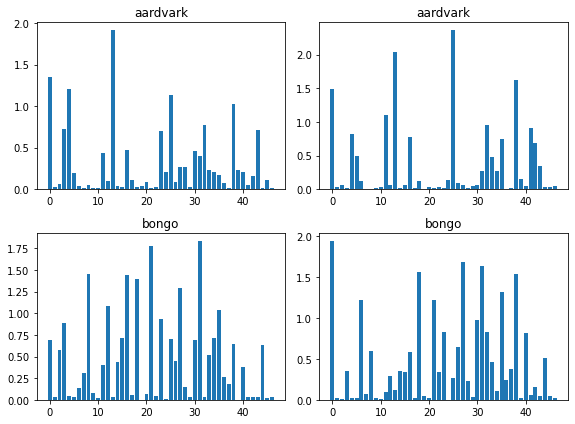

In [27]:
weights_clipped = np.maximum(weights, 0)
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(8, 6))
w_indices = range(weights.shape[1])

ax1.bar(w_indices, weights_clipped[0,:])
target = int(dataset[0][1])
ax1.set_title(idx2obj[target])
ax2.bar(w_indices, weights_clipped[1,:])
target = int(dataset[1][1])
ax2.set_title(idx2obj[target])



ax3.bar(w_indices, weights_clipped[2000,:])
target = int(dataset[2000][1])
ax3.set_title(idx2obj[target])
ax4.bar(w_indices, weights_clipped[2001,:])
target = int(dataset[2001][1])
ax4.set_title(idx2obj[target])
plt.tight_layout()
fig.savefig('weight_distrib.png', dpi=150)
